**Сеть фитнес-центров «Культурист-датасаентист»: Разработка стратегии взаимодействия с клиентами на основе аналитических данных**

Задача - провести анализ и подготовить план действий по удержанию клиентов.

**Шаг 1.** Провести исследовательский анализ данных (EDA)

- Посмотеть на датасет: есть ли в нем отсутствующие признаки, изучите средние значения и стандартные отклонения ;
- Посмотеть на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
- Построить столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построить матрицу корреляций и отобразить её.

**Шаг 2.** Построить модель прогнозирования оттока клиентов

Построить модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:
- Разбить данные на обучающую и валидационную выборку .
- Обучить модель на train-выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.
- Оценить метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравнить по ним модели. 

**Шаг 3.** Сделать кластеризацию клиентов

Отложить в сторону столбец с оттоком и провести кластеризацию объектов (клиентов):
- Стандартизировать данные.
- Построить матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисовать дендрограмму. На основании полученного графика предположить, какое количество кластеров можно выделить. (условие проекта по умолчанию - 5 кластеров)
- Обучить модель кластеризации на основании алгоритма K-Means и спрогнозировать кластеры клиентов. 
- Посмотреть на средние значения признаков для кластеров. 
- Построить распределения признаков для кластеров.
- Для каждого полученного кластера посчитать долю оттока.

**Шаг 4.** Общие выводы и рекомендации

## Исследовательский анализ данных (EDA)

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import median
import math as mth
from scipy import stats as st
import scipy.stats as stats

import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from termcolor import colored
from IPython.display import display

import warnings
warnings.simplefilter('ignore')

In [2]:
#извлекаем датасет
data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
#знакомимся
display(data.head())
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропусков нет вообще нигде, абсолютно все данные численные, это упрощает предобработку.

In [4]:
#изучим средние значения и стандартные отклонения
for col in data.columns:
    print(colored(col, attrs=['bold']))
    print(data[col].describe())

gender
count    4000.000000
mean        0.510250
std         0.499957
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: gender, dtype: float64
Near_Location
count    4000.000000
mean        0.845250
std         0.361711
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Near_Location, dtype: float64
Partner
count    4000.000000
mean        0.486750
std         0.499887
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Partner, dtype: float64
Promo_friends
count    4000.000000
mean        0.308500
std         0.461932
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Promo_friends, dtype: float64
Phone
count    4000.000000
mean        0.903500
std         0.295313
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
m

На первый взгляд можно заметить несколько фактов: 
- Возраст посетителей от 18 до 41 года (среднее 29 лет), довольно молодая аудитория у данного фитнес-клуба. 
- Средняя длительность абонемента - почти 5 месяцев. Лайфтайм клиента в среднем 4 месяца, 75% выборки укладываются в 5 месяцах - вероятно, аудитория клуба выросла относительно недавно. 
- Около 30% посетителей пришли в клуб в рамках акции "приведи друга", довольно большая доля и скорее всего эта акция действительно дает результат. Еще лучше с клиентами сотрудниками фирм-партнеров, их почти половина от всей массы.
- Примерно 85% клиентов проживают/работают в этом же районе, где находится клуб. Это значит, что к нам много людей специально не едут, на выбор фитнеса сильно влияет расположение.

In [5]:
#посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался 
data.groupby('Churn').agg('mean')

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Здесь сразу можно отметить следующее:
- ушли клиенты с намного меньшим периодом действия абонемента - 1,72 месяца против 5,74, что в приницпе логично, человек не будет бросать наперед оплаченную услугу
- групповые тренировки тоже влияют на удержание - в группе оставшихся их посещают 46%, а у отвалившихся - 27%
- по статистике ушедшие клиенты в среднем посещали в клуб не чаще одного раза в неделю в течение последнего месяца, лояльные клиенты ходили в 2 раза чаще. Это скорее всего коррелируется с лайфтаймом, но в любом случае если человек начал редко ходить в клуб, это должно стать "звоночком"
- примерно половина из оставшихся - клиенты из акции "приведи друга", это еще один индикатор эффективности

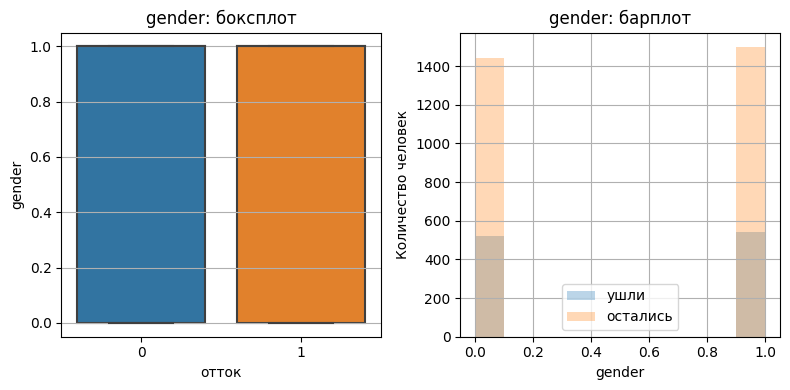

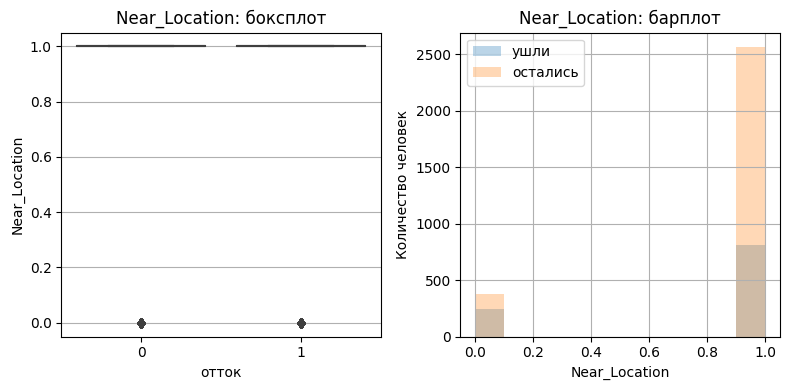

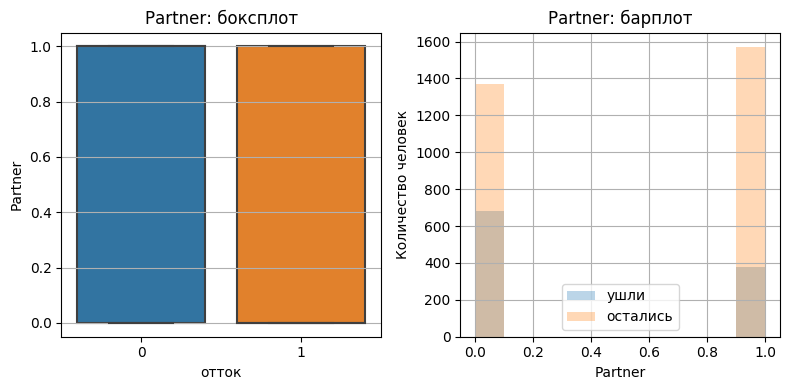

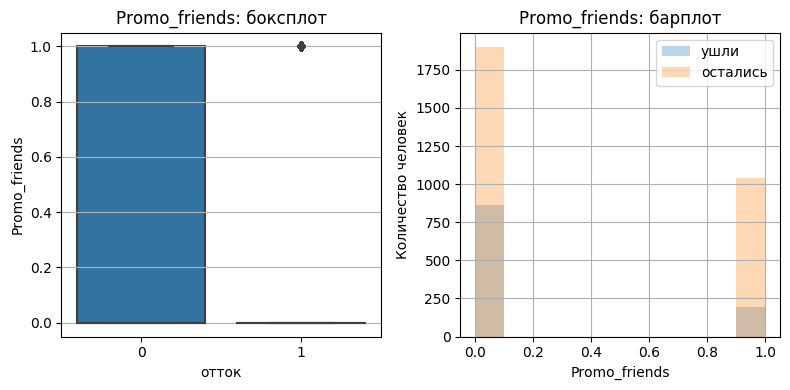

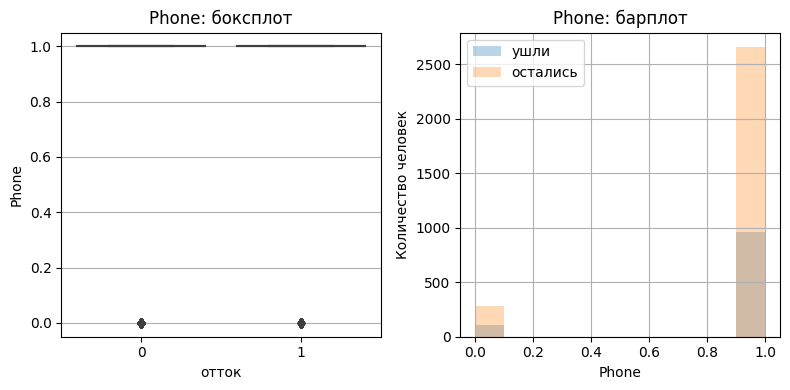

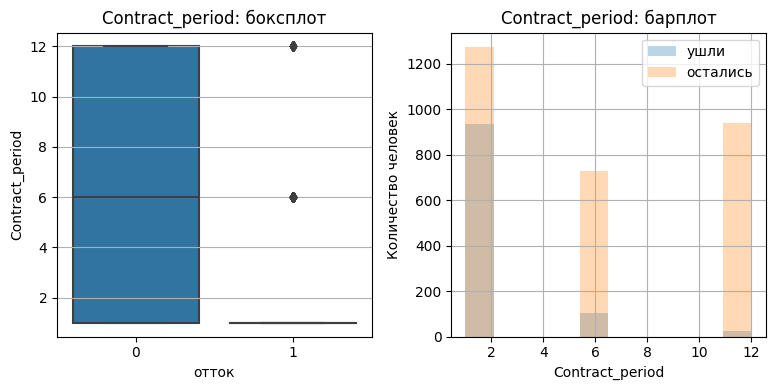

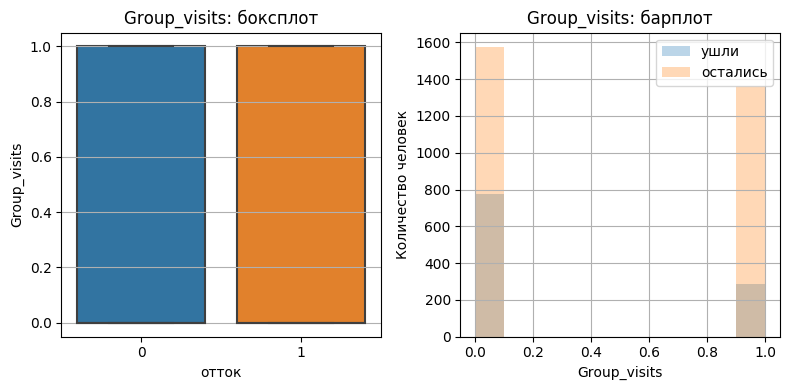

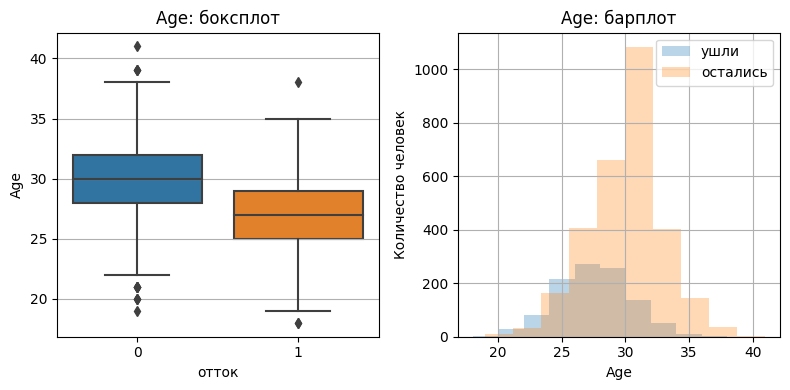

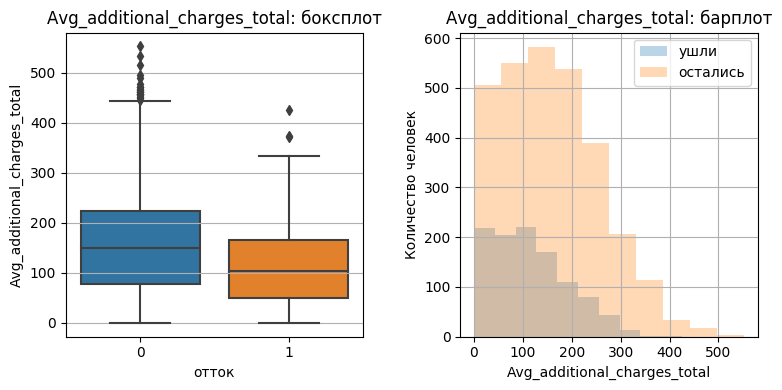

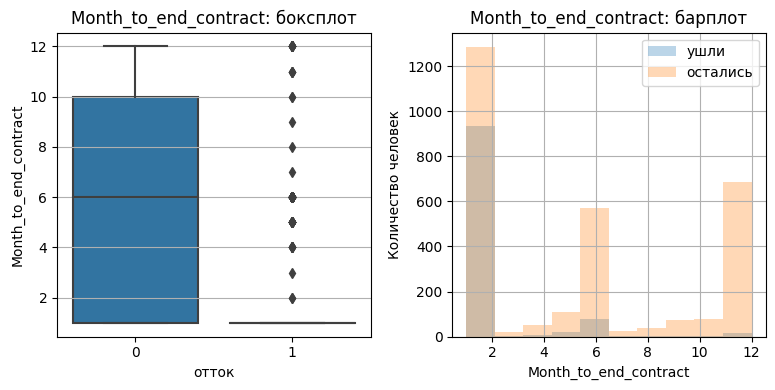

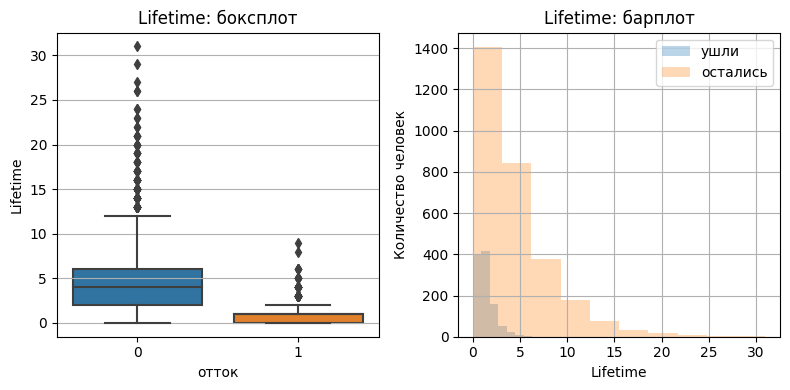

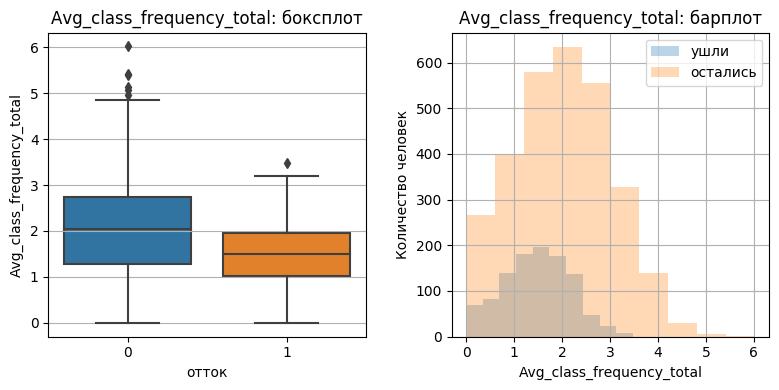

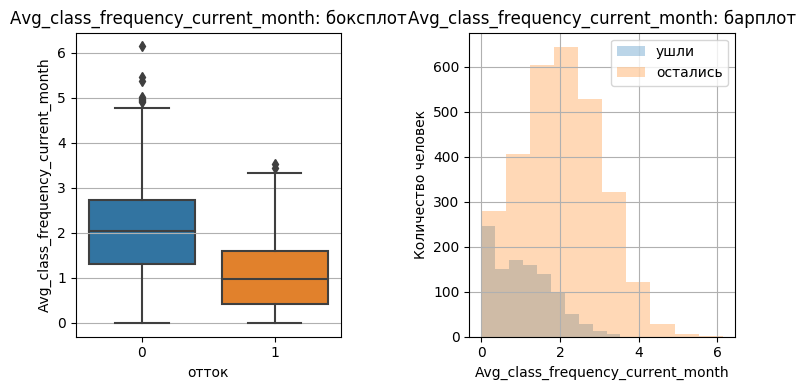

In [6]:
#построим столбчатые гистограммы и распределения признаков
for i in data.drop('Churn', axis = 1).columns:
    plt.figure(figsize=(8,4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.title('{}: боксплот'.format(i))
    plt.grid()
    sns.boxplot(x='Churn', y=i, data=data)
    plt.xlabel('отток')
    
    plt.subplot(1, 2, 2)
    data.query('Churn == 1')[i].plot(kind='hist', alpha=0.3, label='ушли')
    data.query('Churn == 0')[i].plot(kind='hist', alpha=0.3, label='остались')
    plt.grid()
    plt.title('{}: барплот'.format(i))
    plt.xlabel(i)
    plt.ylabel('Количество человек')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

- женщины и мужчины уходят с одинаковой частотой
- из тех, кто далеко живет/работает, отвалилось больше половины, хотя таких в абсолютном значении относительно немного
- партнерская программа положительно влияет на удержание людей, они заметно охотнее остаются клиентами
- уже третий по счету индикатор для акции "приведи друга": больше 75% таких клиентов оседают в клубе
- оттоку более подвержена более молодая аудитория
- есть положительное влияние и у кросс-продаж - клиенты, оставляющие больше денег в фитнес-клубе, немного чаще остаются с ним
- видно, что около 100 человек бросили ходить, хотя у них оставалось еще полгода абонемента. наверняка имеет смысл сделать обзвон таких клиентов и выяснить причины
- если человек проходил в клуб более 6 месяцев, то он скорее всего уже никуда не денется. Значит в эти первые полгода необходимо прилагать максимум усилий по удержанию клиента

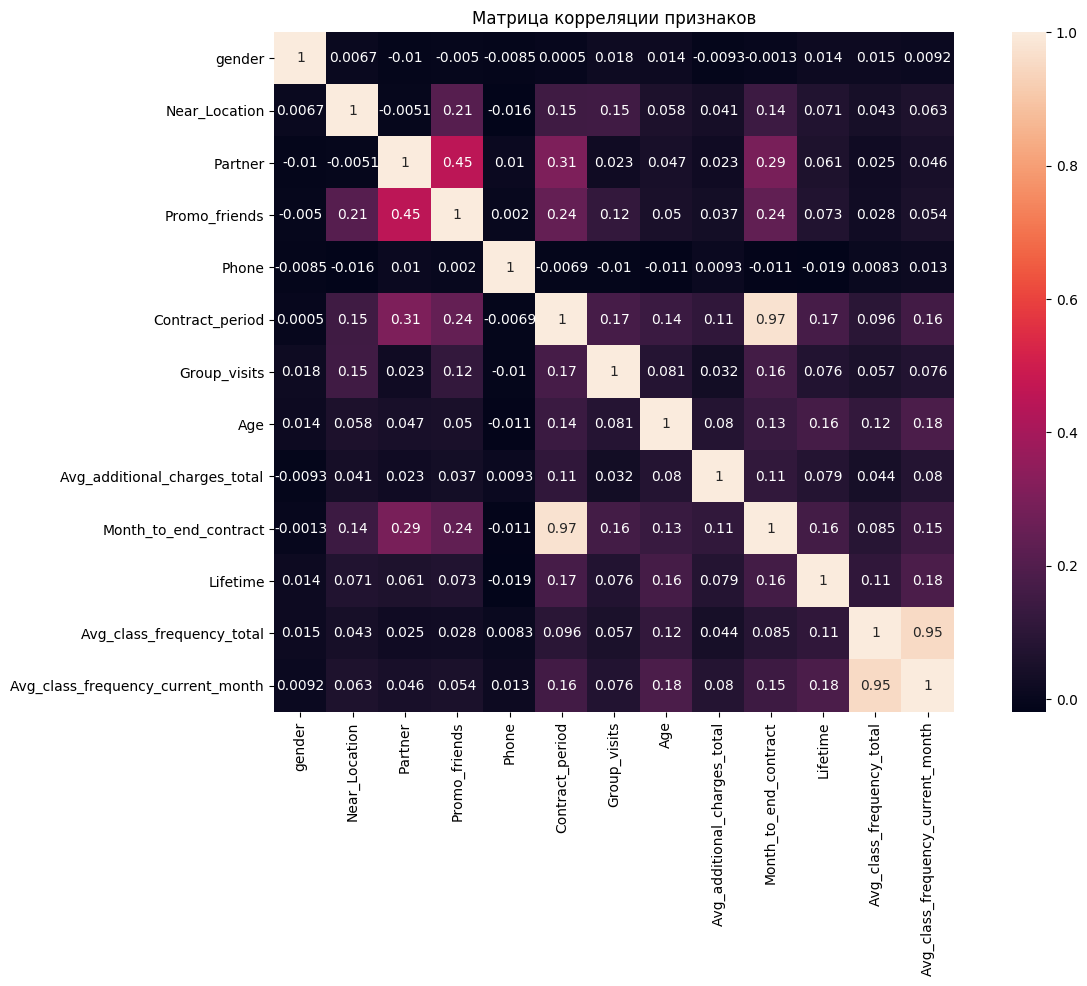

In [7]:
#построим матрицу корреляций и отобразим её
cm = data.drop('Churn', axis = 1).corr()

plt.figure(figsize=(15,9), dpi=100)
plt.title('Матрица корреляции признаков')
sns.heatmap(cm, annot = True, square=True, fmt='.2g')
plt.show()

Сильно коррелируют признаки "средняя частота посещений в неделю" и "средняя частота посещений в месяц", и "срок до окончания абонемента" и "длительность текущего действующего абонемента" - у обоих пар коэффициент 0,95. Чтобы эти признаки не влияли на расчет ML-модели, удалим одни из этих столбцов.

Также выделяются признаки "сотрудник партнера" и "акция приведи друга" - 0,45, но коэффициент находится в приемлимом диапазоне. Остальные признаки имеют слабую корреляцию.

In [8]:
data = data.drop({'Month_to_end_contract','Avg_class_frequency_current_month'}, axis = 1)
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0


## Построение модели прогнозирования оттока клиентов

In [9]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['Churn'])
y = data['Churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)

# зададим список моделей
models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0),
]

#функция, которая принимает на вход модель и данные и выводит метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'ACC:{:.2f} Precision:{:.2f} Recall:{:.2f} '.format(
            accuracy_score(y_test, y_pred),
            precision_score (y_test, y_pred),
            recall_score (y_test, y_pred),
        )
    )

# цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(i, X_train, y_train, X_test, y_test)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
ACC:0.90 Precision:0.83 Recall:0.80 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
ACC:0.88 Precision:0.81 Recall:0.73 


Модель логистической регрессии и случайного леса показали практически идентичные результаты по метрикам Доли правильных ответов, то есть доля верно угаданных ответов из всех прогнозов (accuracy) - 90% и 88%, и Точности (доли правильных ответов только среди целевого класса, Precision score) - 83 и 81 процент соответственно. 

Однако в показателе Recall, которая показывает, сколько реальных объектов "1" класса мы смогли обнаружить, мотель Логистической регрессии показала себя чуть лучше - 80% против 73% у Случайного леса. Поэтому в рамках исследования эта модель оказалась более предпочтительной для выбора в дальнейшем использовании.

## Кластеризация клиентов

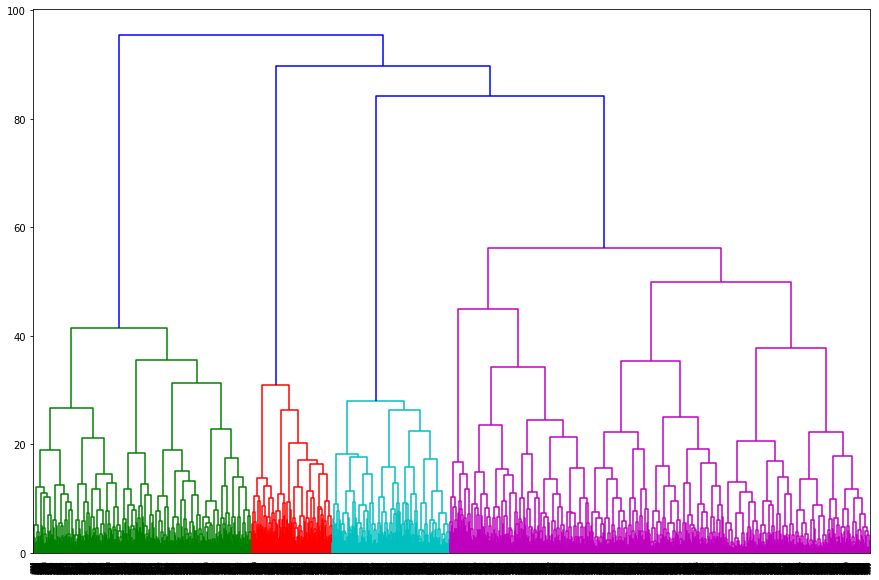

In [10]:
#стандартизируем данные, удалив столбец с оттоком
sc = StandardScaler()
X_sc = sc.fit_transform(data.drop('Churn', axis=1))

linked = linkage(X_sc, method = 'ward')

#строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Проведя агломеративную иерархическую кластеризацию признаков и построив дендрограмму, можно увидеть, что клиентов можно разбить на 4 кластера. Однако по условиям задачи 5 кластеров принято по умолчанию, расчет на 4 можно сделать как альтернативу.

In [11]:
# задаём число кластеров, равное 5
km = KMeans(n_clusters = 5, random_state=0) 

# применяем алгоритм к данным и формируем вектор кластеров 
labels = km.fit_predict(X_sc) 

# сохраняем метки кластера в поле нашего датасета
data['cluster'] = labels

In [12]:
#посмотрим на средние значения признаков для кластеров
display(data.groupby('cluster').agg({'mean'}))

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Lifetime,Avg_class_frequency_total,Churn
,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean,mean
cluster,,,,,,,,,,,,
0,0.499109,0.000000,0.488414,0.076649,1,3.032086,0.235294,28.721925,137.540009,3.060606,1.770413,0.399287
1,0.488571,0.995238,0.955238,0.892381,1,7.660952,0.458095,29.543810,155.861428,4.380952,1.978963,0.120952
2,0.505300,1.000000,0.238516,0.059187,1,2.819788,0.000000,28.770318,143.383993,3.343640,1.800647,0.381625
3,0.544202,1.000000,0.250287,0.079219,1,4.528129,1.000000,29.536165,148.088897,3.761194,1.941342,0.200918
4,0.523316,0.862694,0.471503,0.305699,0,4.777202,0.427461,29.297927,144.208179,3.940415,1.854211,0.266839


Взглянув на средние значения признаков для кластеров, можно сразу увидеть следующее:
- в 0-ом кластере все клиенты живут/работают не в одном районе с фитнес-клубом, в остальных наоборот практически все рядом.
- в 1-ом кластере преобладают клиенты партнеров клуба - 96% и 89% пришли по акции "приведи друга"
- в 4-м кластере ни у кого нет телефона
- 1-ый кластер с самым продолжительным сроком абонементов (более 7 мес)
- 1-ый кластер относительно больше других делает доп.покупки в клубе, и там самый большой средний lifetime клиентов - почти 4 с половиной месяца
- чаще всех в клуб ходит 1-ый и 3-ий кластер - в среднем почти 2 раз в неделю

Распределения признаков для кластеров
 


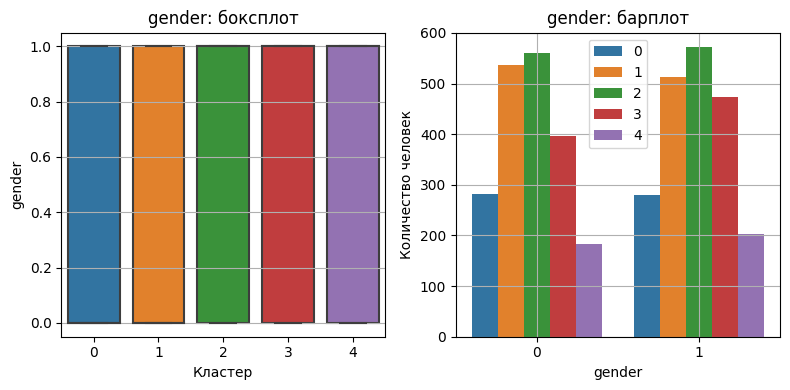

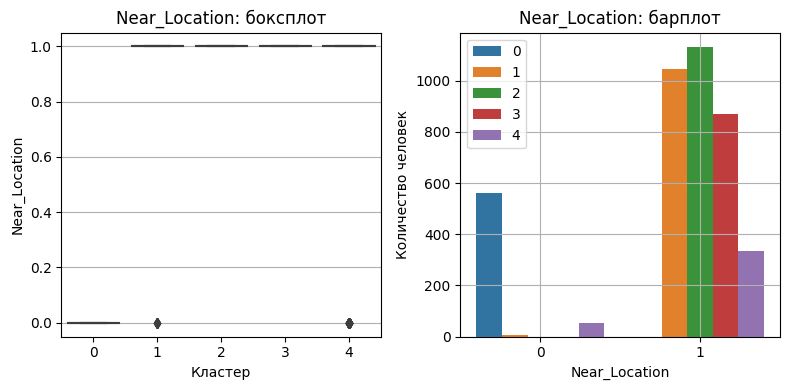

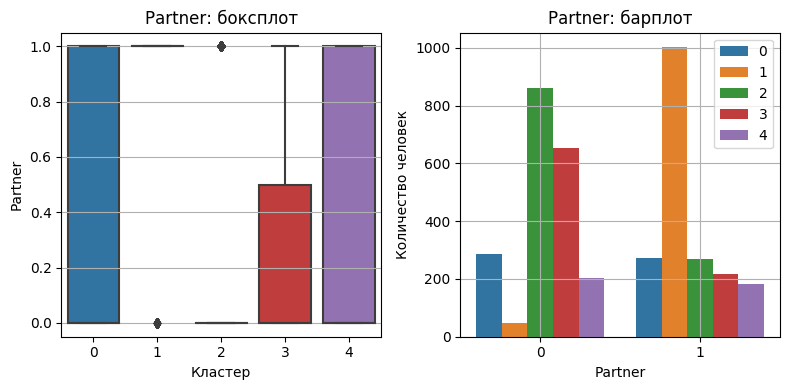

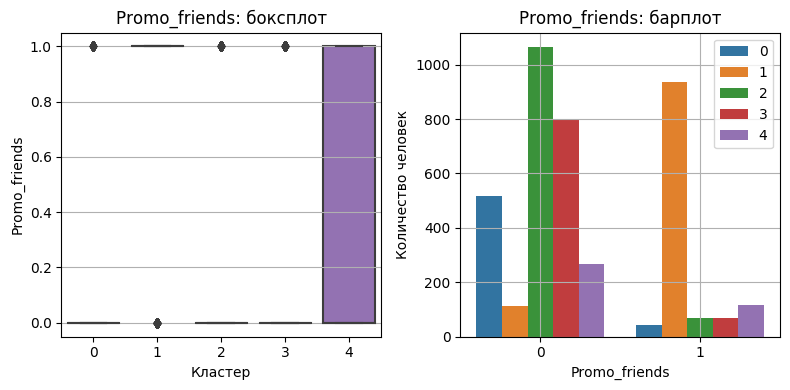

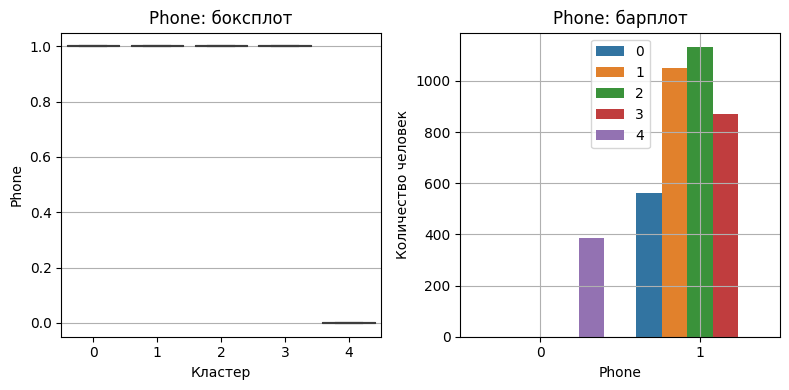

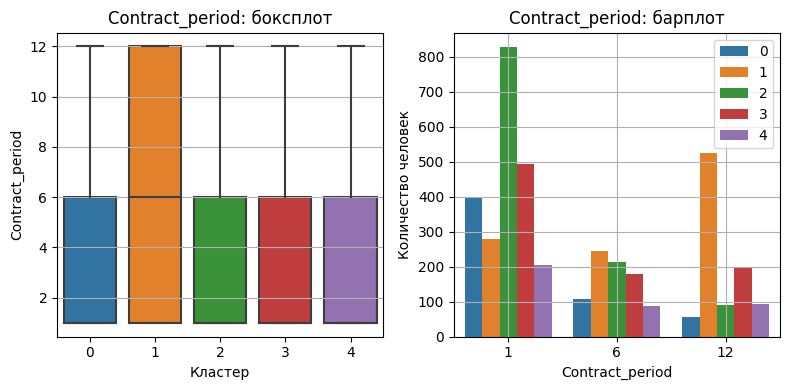

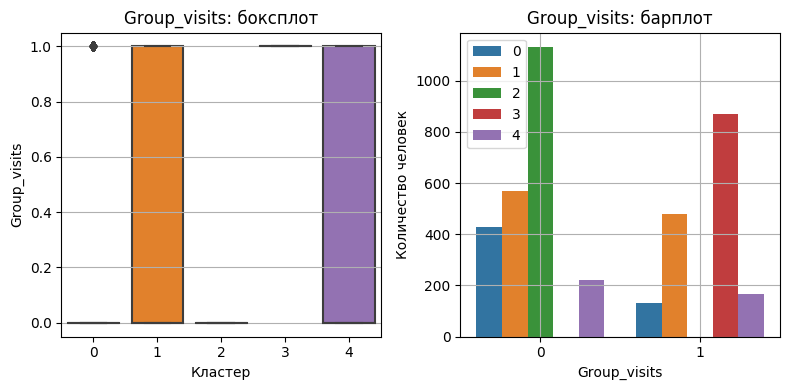

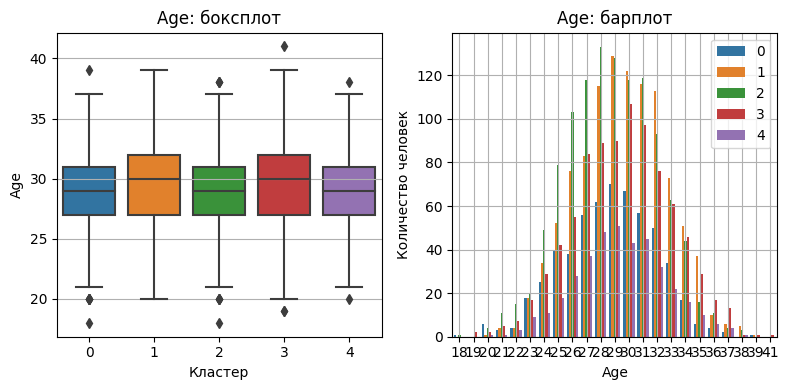

In [ ]:
#построим распределения признаков для кластеров
print('Распределения признаков для кластеров')    
print(' ')  
for i in data.columns:
    plt.figure(figsize=(8,4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.title('{}: боксплот'.format(i))
    plt.grid()
    sns.boxplot(x='cluster', y=i, data=data)
    plt.xlabel('Кластер')    
    
    plt.subplot(1, 2, 2)
    sns.countplot(data = data, x = i, hue = 'cluster')
    plt.grid()
    plt.title('{}: барплот'.format(i))
    plt.xlabel(i)
    plt.ylabel('Количество человек')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

Построив графики распределения признаков для кластеров, из новых фактов можно заметить следующее:
- пол распределен равномерно для всех кластеров
- во 2-м кластере продолжительность абонемента у большей части выборки 1 месяц, есть немного клиентов с абонементами в 6 и 12 месяцев, которые завышают среднее значение
- 0-ой и 2-ой кластеры реже других ходят на групповые тренировки (практически не ходят), 3-ий наоборот только туда и ходит
- возраст клиентов во всех кластерах отличается незначительно

In [ ]:
#Для каждого полученного кластера посчитаем долю оттока
data.groupby('cluster').agg({'Churn':'mean'})

Топ кластеров по оттоку: 
- 0 кластер: 40%
- 2 кластер: 38%
    
Самые надежные кластеры **1** (12%) и **3** (20%)

## Общие выводы и рекомендации

Основная аудитория фитнес-клуба пришла относительно недавно, вероятно, была проведена одна или несколько успешных рекламных кампаний, и теперь необходимо спланировать действия для удержания клиентов. Для формирования стратегии следует исходить из подсвечивания основных признаков тех кластеров, которые больше других подвержены оттоку, а также обратить внимание на общие триггеры оттока:
- основной отток среди тех клиентов, у которых "короткий" абонемент (1мес) и которые живут/работают не в нашем районе
- чем меньше человек ходит в клуб и меньше он тратит на допуслуги, тем больше вероятность, что он "отвалится"
- посещение групповых тренировок и наличие телефона - тоже факторы, которые влияют на отток
- акцию "приведи друга" и партнерскую программу можно признать очень успешной - они генерируют очень "качественных", в будущем лояльных клиентов

Соответственно, можно предположить следующие направления работы по удержанию клиентов:
- стимуляция к покупке "длинного" абонемента (больше 6 месяцев) - разнообразные виды скидок и бонусов от партнеров при выборе такой продолжительности. Так мы снизим вероятность того, что клиент передумает к нам ходить, т.к. по общей статистике при лайфтайме клиента более полугода он остается в клубе.
- стимуляция клиента к посещению групповых тренировок, особенно в первые 6 месяцев после первой покупки абонемента. Это может быть смс-информирование, разработка разных видов тренировок, приглашение известных тренеров и т.д. Особое внимание здесь необходимо уделить тем клиентам, которые находятся не в нашем районе, т.к. такие люди чаще всего отваливаются из-за непосещения групповых тренировок.
- маркетинг внутри клуба - стимуляция клиента к доп.покупкам, так называемый "engage"-фактор, фактор вовлеченности, который позволит "захватить" интерес клиента к посещению клуба
- если клиент снизил частоту посещения клуба до 1 раза в неделю, то следует провести дополнительную коммуникацию такой группой, как минимум через смс или email информирование
- при регистрации клиента обязательно просить указывать номер мобильного телефона, т.к. это может быть единственный канал общения с ним, и при его отсутствии повышается вероятность их оттока